In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
plot_dir = "/home/llr/ilc/shi/code/Energy-Reco/Figures"
plot_conf="SamplingLayer"
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
def clean_number(x):
    s = f"{x:g}"          # g 格式自动去掉不必要的小数
    return s
figSize = (8, 6)
axhline_lr=1.5
# Read Data
Config = ("SumE", "NHits","RecoE_MLP")
Legend = ("SumE", "NHits", "MLP")
TotalLayer=120
SamplingLayer = (60,40,30,24,20)
colors = ['blue', 'green', 'red','orange','purple','brown','cyan','magenta']
dataPath = "/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate"
particleEnergy = []
meanGamma = []
meanGammaErr = []
peakGamma = []
peakGammaErr = []
resGamma = []
resGammaErr = []

for layer in SamplingLayer:
    layer_particleEnergy = []
    layer_meanGamma = []
    layer_meanGammaErr = []
    layer_peakGamma = []
    layer_peakGammaErr = []
    layer_resGamma = []
    layer_resGammaErr = []
    dataPath_layer = os.path.join(dataPath, f"Merged_X5.0mm_Y5.0mm_Si0.75mm_layer{layer}_in{TotalLayer}/Reco_Results")
    
    for i_config in range(len(Config)):
        fileName = os.path.join(dataPath_layer, f"{Config[i_config]}_Fit.csv")
        df = pd.read_csv(fileName)
        
        layer_particleEnergy.append(df["ParticleEnergy"].to_numpy())
        layer_meanGamma.append(df["Mean_Gamma"].to_numpy())
        layer_meanGammaErr.append(df["Mean_Gamma_Error"].to_numpy())
        layer_peakGamma.append(df["Peak_Gamma"].to_numpy())
        layer_peakGammaErr.append(df["Peak_Gamma_Error"].to_numpy())
        layer_resGamma.append(df["Res_Gamma"].to_numpy())
        layer_resGammaErr.append(df["Res_Gamma_Error"].to_numpy())
        
        print(f"Loaded {fileName}")
    
    particleEnergy.append(layer_particleEnergy)
    meanGamma.append(layer_meanGamma)
    meanGammaErr.append(layer_meanGammaErr)
    peakGamma.append(layer_peakGamma)
    peakGammaErr.append(layer_peakGammaErr)
    resGamma.append(layer_resGamma)
    resGammaErr.append(layer_resGammaErr)



Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer60_in120/Reco_Results/SumE_Fit.csv
Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer60_in120/Reco_Results/NHits_Fit.csv
Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer60_in120/Reco_Results/RecoE_MLP_Fit.csv
Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer40_in120/Reco_Results/SumE_Fit.csv
Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer40_in120/Reco_Results/NHits_Fit.csv
Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer40_in120/Reco_Results/RecoE_MLP_Fit.csv
Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/M

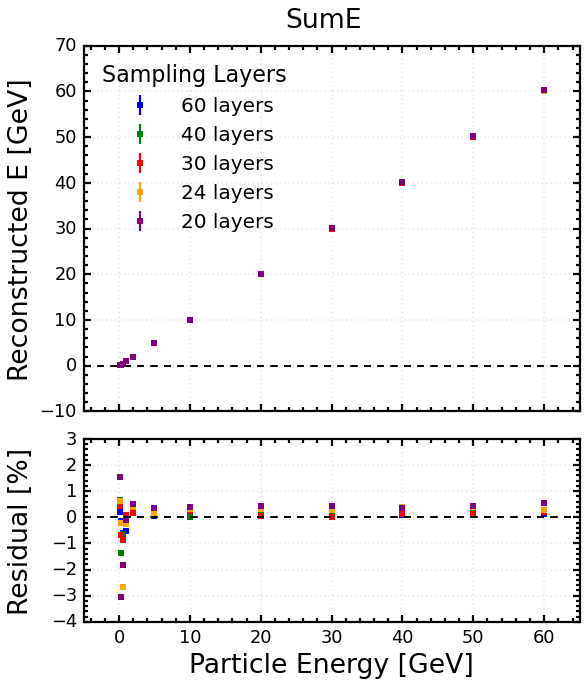

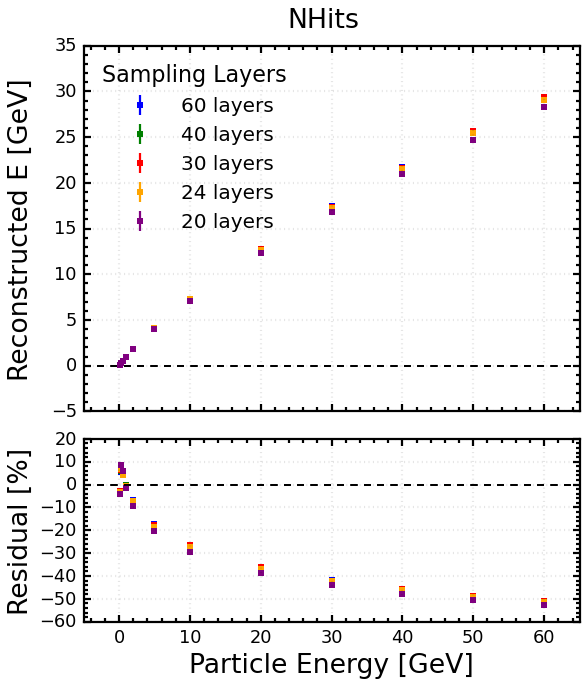

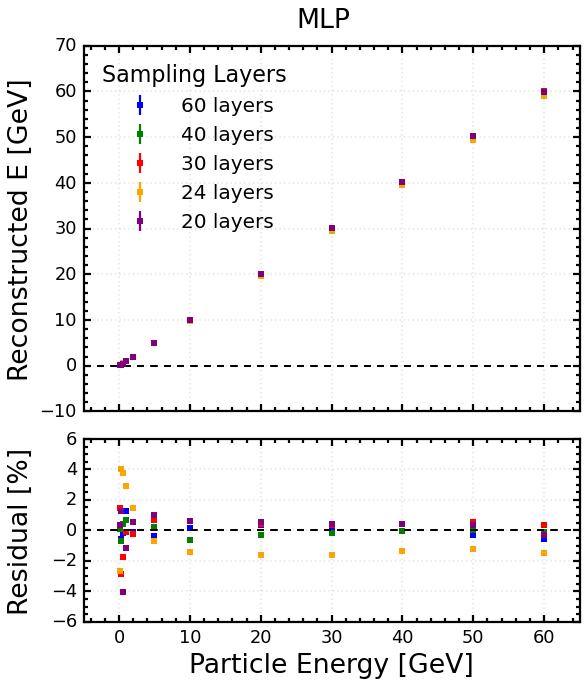

In [6]:

# Linearity and Resolution
def linear_func(x, a, b):
    return a * x + b

def fitAndResidualRatio(x, y, fit_range=(0,30)):
    """Linear fit and return coefficients, fit values, and relative residuals."""
    a0 = (y[-1] - y[0]) / (x[-1] - x[0])
    b0 = y[0]
    p0 = [a0, b0]
    upper_bound = [5*a0, np.inf]
    lower_bound = [0, -np.inf]  # Ensure slope is non-negative
    mask = (x >= fit_range[0]) & (x <= fit_range[1])
    coeffs, cov = curve_fit(linear_func, x[mask], y[mask], p0=p0, bounds=(lower_bound, upper_bound),sigma=x[mask], absolute_sigma=True)
    fitVals = linear_func(x, *coeffs)
    residualRatio = (y - fitVals) / fitVals
    return coeffs, fitVals, residualRatio

for config_idx, config in enumerate(Config):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(figSize[0], figSize[1]*1.6),
                                   sharex=True, gridspec_kw={'height_ratios':[1, 0.5], 'hspace':0.1})

    for ax in [ax1, ax2]:
        ax.yaxis.set_label_coords(-0.1, 0.5)  # x in axes coords, unify manually
    for layer_idx, layer in enumerate(SamplingLayer):
        x = particleEnergy[layer_idx][config_idx]
        y = peakGamma[layer_idx][config_idx]
        y_err = peakGammaErr[layer_idx][config_idx]

        # Calib
        fit_range = (0, 2) if config == "NHits" else (0, 60)
        coeff, fitVals, residual = fitAndResidualRatio(x, y, fit_range=fit_range)
        y_calib = (y - coeff[1]) / coeff[0]
        y_err = y_err / coeff[0]
        #resGamma[cell_idx][config_idx] = (resGamma[cell_idx][config_idx] * y / coeff[0]) / y_calib
        coeff, fitVals, residual = fitAndResidualRatio(x, y_calib, fit_range=fit_range)
        residual = (y_calib - x) / x
        ax1.errorbar(x, y_calib, yerr=y_err, fmt='s', capsize=4,
                     color=colors[layer_idx], label=f"{layer} layers")
        ax1.set_ylabel("Reconstructed E [GeV]")
        ax1.axhline(0, color='black', lw=axhline_lr, linestyle='--')
        ax1.set_xlim(-5, 65)
        ax1.legend(loc='upper left', fontsize=18, title="Sampling Layers", title_fontsize=20)

        # Residual plot
        ax2.plot(x, residual*100, 's', color=colors[layer_idx])
        ax2.axhline(0, color='black', lw=axhline_lr, linestyle='--')
        ax2.set_xlabel(r"Particle Energy [GeV]")
        ax2.set_ylabel("Residual [%]")

    fig.suptitle(f"{Legend[config_idx]}", fontsize=24, y=0.95)
    plt.savefig(os.path.join(plot_dir, f"Linearity_{plot_conf}_{Legend[config_idx]}.pdf"), dpi=300, bbox_inches='tight')
    plt.show()
    



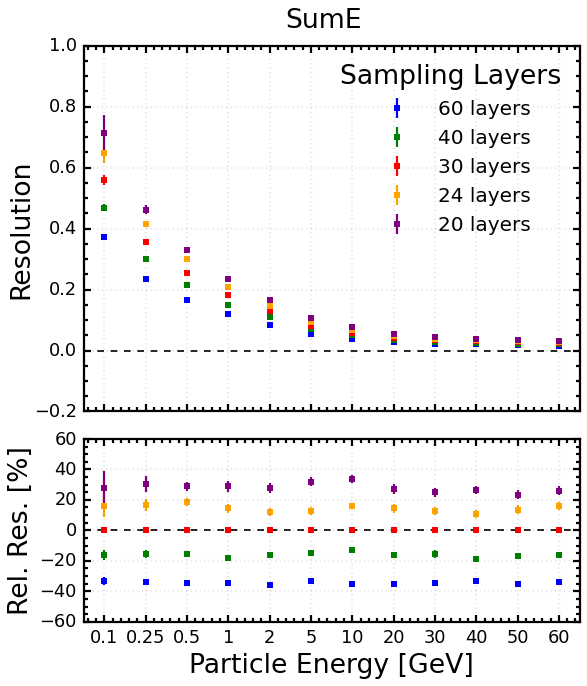

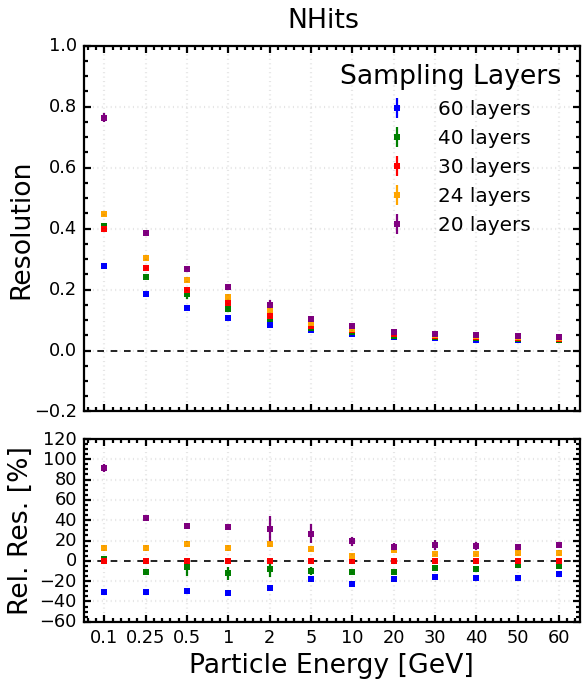

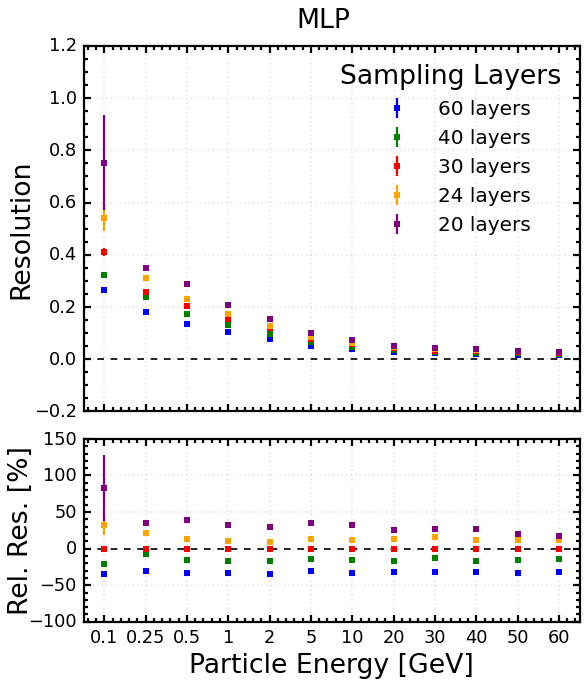

In [7]:
MarkerSize = 10
for i_c, config in enumerate(Config):
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(figSize[0], figSize[1]*1.6),
        sharex=True, gridspec_kw={'height_ratios': [1, 0.5], 'hspace': 0.1}
    )

    for ax in [ax1, ax2]:
        ax.yaxis.set_label_coords(-0.1, 0.5)  # x in axes coords, unify manually
    ref_idx = 2
    y_ref = np.array(resGamma[ref_idx][i_c])
    y_ref_err = np.array(resGammaErr[ref_idx][i_c])

    # -----------------------------
    # 1. 用点索引作为横坐标（均匀）
    # -----------------------------
    E_ref = np.array(particleEnergy[0][i_c])   # 用一个 cell 的能量作为 tick
    num_points = len(E_ref)
    x_idx = np.arange(num_points)              # 均匀点位置

    # -----------------------------
    # 2. 主图绘制
    # -----------------------------
    for layer_idx, layer in enumerate(SamplingLayer):
        y_vals = np.array(resGamma[layer_idx][i_c])
        y_errs = np.array(resGammaErr[layer_idx][i_c])
        ax1.errorbar(
            x_idx, y_vals, yerr=y_errs,
            fmt='s', capsize=4,
            label=f"{layer} layers",
            color=colors[layer_idx]
        )

        # -----------------------------
        # 3. Residual
        # -----------------------------
        if layer_idx == ref_idx:
            ax2.errorbar(
                x_idx, np.zeros_like(y_vals), yerr=y_errs / y_ref,
                fmt='s', capsize=4, label=f"{layer} layers (ref)",
                color=colors[layer_idx]
            )
        else:
            u = y_vals / y_ref
            residual = u - 1
            residual_err = u * np.sqrt((y_errs / y_vals)**2 + (y_ref_err / y_ref)**2)

            ax2.errorbar(
                x_idx, residual * 100, yerr=residual_err * 100,
                fmt='s', capsize=4, label=f"{layer} layers / ref",
                color=colors[layer_idx]
            )

    # -----------------------------
    # 4. X轴刻度按 E（GeV）显示
    # -----------------------------
    ax1.set_xticks(x_idx)  
    ax1.set_xticklabels([clean_number(e) for e in E_ref])  # 显示能量

    # Y/X label
    ax1.set_ylabel("Resolution")
    ax1.axhline(0, color='black', lw=axhline_lr, linestyle='--')
    ax1.set_xlim(-0.5, num_points - 0.5)
    ax1.legend(loc='upper right', fontsize=18, title="Sampling Layers", title_fontsize=24)

    ax2.axhline(0, color='black', lw=axhline_lr, linestyle='--')
    ax2.set_xlabel("Particle Energy [GeV]")   # 主轴显示 E
    ax2.set_ylabel("Rel. Res. [%]")

    fig.suptitle(f"{Legend[i_c]}", fontsize=24, y=0.95)
    plt.savefig(os.path.join(plot_dir, f"Resolution_{plot_conf}_{Legend[i_c]}.pdf"), dpi=300, bbox_inches='tight')
    plt.show()
